In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score,classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from xgboost import plot_importance

file_path = '/kaggle/input/hotel-booking-demand/hotel_bookings.csv'

df = pd.read_csv(file_path)
print("Shape :",df.shape)
print(df.head())
print("\n Cancellation Rate : \n",df['is_canceled'].value_counts(normalize=True))



Shape : (119390, 32)
          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2  ...   

In [25]:
df['children'] = df['children'].fillna(0)
df['country'] = df['country'].fillna('Unknown')
df['agent']=df['agent'].fillna(0)
df['company']= df['company'].fillna(0)
cols_to_drop = ['reservation_status_date','reservation_status']
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
print('missing = ',df.isnull().sum().sum()) # = 0 okay 


missing =  0


In [26]:
X = df.drop('is_canceled',axis=1)
y = df['is_canceled']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
print('Train shape ',X_train.shape)

Train shape  (95512, 29)


In [27]:
cat_cols = [
    "hotel","arrival_date_month","meal","country","market_segment",
    "distribution_channel","reserved_room_type","assigned_room_type",
    "deposit_type","customer_type"
]
cat_cols = [c for c in cat_cols if c in X_train.columns]
cat_features = [X_train.columns.get_loc(c) for c in cat_cols]

In [29]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=200
)
model.fit(X_train,y_train,cat_features=cat_features)

0:	total: 212ms	remaining: 3m 31s
200:	total: 26.4s	remaining: 1m 44s
400:	total: 52.2s	remaining: 1m 17s
600:	total: 1m 18s	remaining: 52s
800:	total: 1m 45s	remaining: 26.1s
999:	total: 2m 11s	remaining: 0us


In [31]:
proba = model.predict_proba(X_test)[:,1]
preds = (proba >=0.5).astype(int)
print("AUC-ROC:", roc_auc_score(y_test, proba))
print("\nClassification Report:\n", classification_report(y_test, preds))

AUC-ROC: 0.9538557325758215

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91     15033
           1       0.86      0.81      0.83      8845

    accuracy                           0.88     23878
   macro avg       0.88      0.87      0.87     23878
weighted avg       0.88      0.88      0.88     23878



In [35]:
importances = model.get_feature_importance()
feature_names = model.feature_names_

# Build dataframe
fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False).head(15)

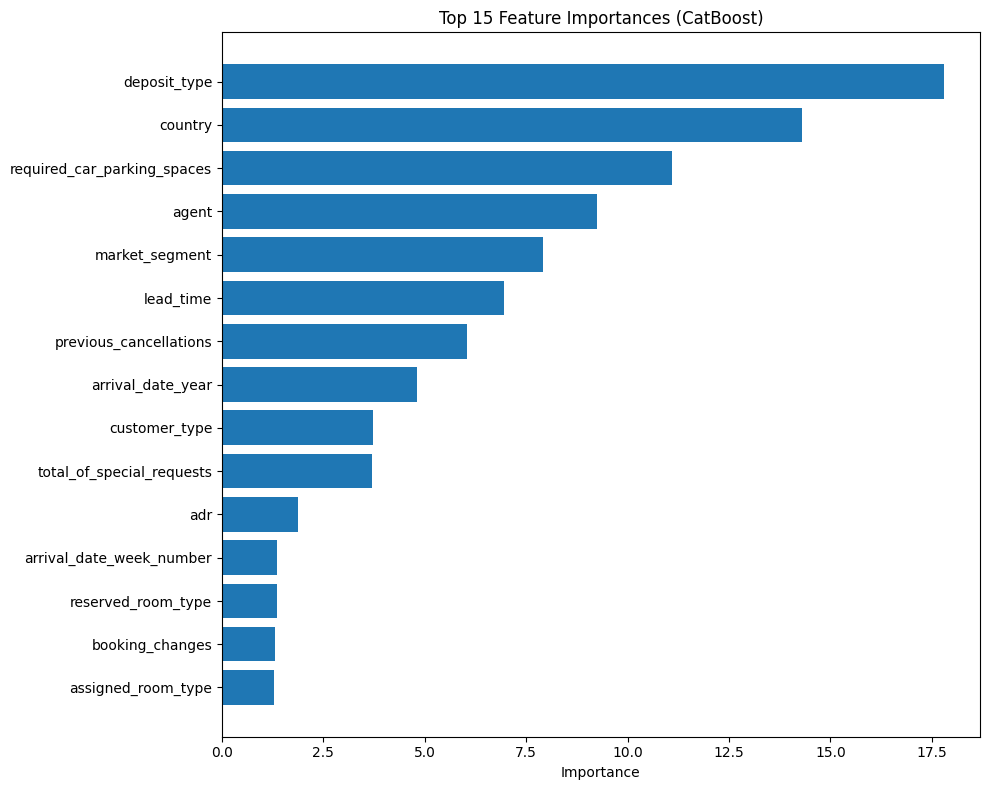

In [36]:
plt.figure(figsize=(10, 8))
plt.barh(fi["feature"][::-1], fi["importance"][::-1])
plt.xlabel("Importance")
plt.title("Top 15 Feature Importances (CatBoost)")
plt.tight_layout()
plt.show()

In [37]:
model.save_model("hotel_fraud_model.json")